In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

/Users/marxena/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


### BHEX Mini Secondary Science Targets (SSTs)

In [2]:
radio_targets = [
    ("3C 84", 3.06, 20),
    # ("3C 279", 13.00, 80),
    # ("OJ 287", 2.49, 172),
    ("NRAO 530", 0.55, 63),
    ("NGC 1052", 0.41, 30),
    ("BL Lac", 0.76, 52),
    ("3C 273", 3.72, 66),
    ("3C 454.3", 4.42, 63),
    ("3C 345", 2.58, 53),
    ("CTA 102", 3.10, 54),
    ("PKS 0528+134", 2.00, 50),
    ("PKS 1510-089", 1.30, 43),
    ("1730-130", 2.38, 42),
    ("0716+714", 1.46, 60),
    ("1921-293", 2.10, 58),
    ("1749+096", 1.60, 70),
    ("1633+382", 1.85, 45),
    ("0420-014", 2.04, 39),
    ("0235+164", 1.28, 55),
    ("2145+067", 1.02, 68),
    ("1334-127", 1.21, 72),
    ("2223-052", 1.38, 63),
    ("2134+004", 0.93, 56),
    ("1611+343", 1.09, 51),
    ("2251+158", 4.42, 63)
]

df_csv = pd.DataFrame(radio_targets, columns=["Target", "Flux Density (Jy)", "Angular Size (μas)"])

print(df_csv.loc[0][1])

3.06


### Calculate Baseline Length

In [3]:
def baseline_length(km_baseline_length):
  observing_frequency = 86e9 # Hz units
  b = km_baseline_length * (10**3) # convert km to m
  llambda = 3e8 / observing_frequency # gives λ in m
  return b / (llambda * 10**9) # return baseline_length in Gλ

ss_max = baseline_length(32400) # max space-space baseline
ss_min = baseline_length(19600) # min space-space

sg_max = baseline_length(12400) # max space-ground
sg_min = baseline_length(400) # min space-ground

baselines = [ss_max, ss_min, sg_max, sg_min]

print(baselines)

[9.288, 5.618666666666666, 3.5546666666666664, 0.11466666666666667]


### Calculate Visibility Amplitude

In [4]:
def visibility_amplitude(flux_density, angular_size, baseline_length):
  b = baseline_length * (10**9) # get into GHz
  theta = angular_size * (10**-6) * (np.pi/180) * (1/3600) # convert µas to as, as to degrees, degrees to radians
  V = flux_density * np.exp(-1 * (np.pi * theta * b)**2 / (4 * np.log(2))) # visibility amplitude formula from slides
  return V

In [5]:
V_ss_max = []
V_ss_min = []

V_sg_max = []
V_sg_min = []

for i in range(len(radio_targets)):
  V_ss_max.append(visibility_amplitude(df_csv.loc[i, "Flux Density (Jy)"], df_csv.loc[i, "Angular Size (μas)"], ss_max))
  V_ss_min.append(visibility_amplitude(df_csv.loc[i, "Flux Density (Jy)"], df_csv.loc[i, "Angular Size (μas)"], ss_min))

  V_sg_max.append(visibility_amplitude(df_csv.loc[i, "Flux Density (Jy)"], df_csv.loc[i, "Angular Size (μas)"], sg_max))
  V_sg_min.append(visibility_amplitude(df_csv.loc[i, "Flux Density (Jy)"], df_csv.loc[i, "Angular Size (μas)"], sg_min))

df_visibility = pd.DataFrame({
    "Target": df_csv["Target"],
    "V_ss_max": V_ss_max,
    "V_ss_min": V_ss_min,
    "V_sg_max": V_sg_max,
    "V_sg_min": V_sg_min
})

# df_visibility

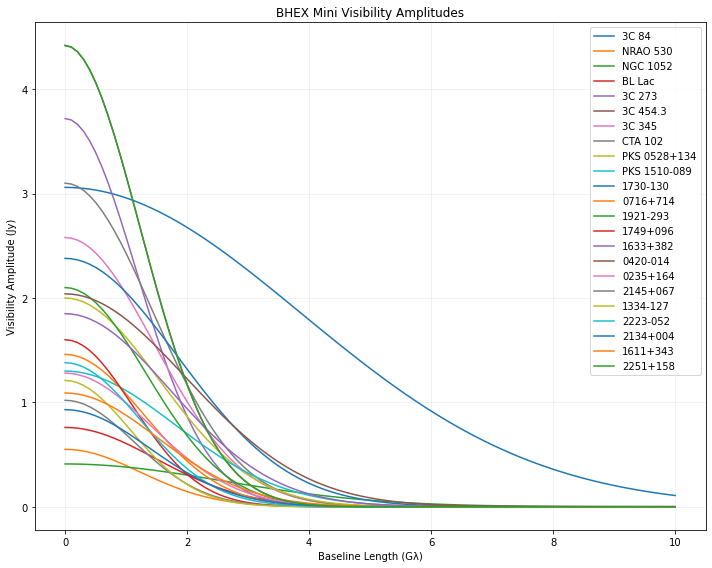

In [6]:
baselines_inputs = np.linspace(0, 10, 100)

plt.figure(figsize=(10, 8))

for index, row in df_csv.iterrows():
  target_name = row["Target"]
  flux_density = row["Flux Density (Jy)"]
  angular_size = row["Angular Size (μas)"]
  vis_amps = [visibility_amplitude(flux_density, angular_size, b) for b in baselines_inputs]
  plt.plot(baselines_inputs, vis_amps, label=target_name)

plt.xlabel("Baseline Length (Gλ)")
plt.ylabel("Visibility Amplitude (Jy)")
plt.title("BHEX Mini Visibility Amplitudes")
plt.grid(alpha=0.2)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('BHEXMiniVisAmpsAllTargets.png', dpi=600)
plt.show()

### Calculate Thermal Noise Constraint

In [7]:
def thermalNoise_constraint(V, SNR=5):
  return V/SNR

noise_ss_max, noise_ss_min = [], []
noise_sg_max, noise_sg_min = [], []

for i in range(0, len(df_visibility)):
  noise_ss_max.append(thermalNoise_constraint(df_visibility.loc[i][1]))
  noise_ss_min.append(thermalNoise_constraint(df_visibility.loc[i][2]))

  noise_sg_max.append(thermalNoise_constraint(df_visibility.loc[i][3]))
  noise_sg_min.append(thermalNoise_constraint(df_visibility.loc[i][4]))

In [8]:
df_thermal_noise = pd.DataFrame({
    "Target": df_csv["Target"],
    "ss_max": noise_ss_max,
    "ss_min": noise_ss_min,
    "sg_max": noise_sg_max,
    "sg_min": noise_sg_min
})

# df_thermal_noise

# print(df_thermal_noise.loc[0][2])

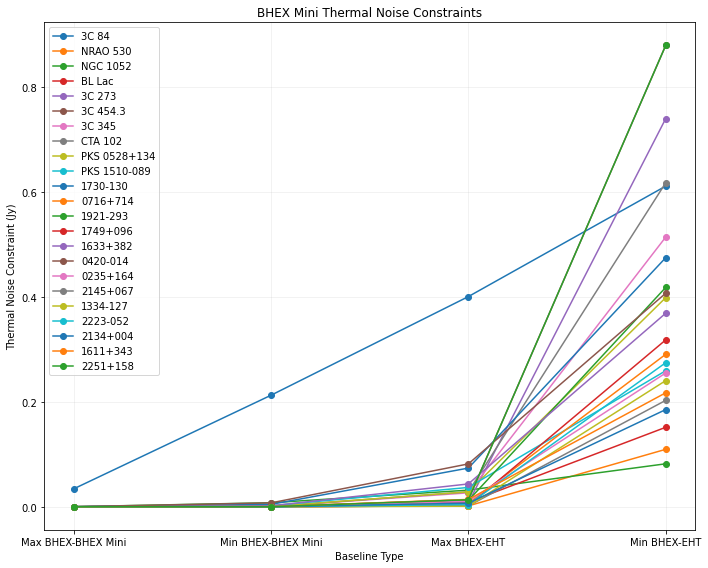

In [9]:
plt.figure(figsize=(10, 8))

# Plotting thermal noise for each target as separate lines
for index, row in df_thermal_noise.iterrows():
  target_name = row["Target"]
  baselines_labels = ["Max BHEX-BHEX Mini", "Min BHEX-BHEX Mini", "Max BHEX-EHT", "Min BHEX-EHT"]
  noise_values = [row["ss_max"], row["ss_min"], row["sg_max"], row["sg_min"]]
  # Plotting as a line plot
  plt.plot(baselines_labels, noise_values, marker='o', linestyle='-', label=target_name)

plt.xlabel("Baseline Type")
plt.ylabel("Thermal Noise Constraint (Jy)")
plt.title("BHEX Mini Thermal Noise Constraints")
plt.grid(alpha=0.2)
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('BHEXMiniThermalNoise.png', dpi=300)
plt.show()

### Calculate Sensitivity Constraint

In [10]:
def SEFD_BHEXMini(thermalNoise, eta_Q, bandwidth, coherenceTime, SEFD_BHEX):
  SEFD = (thermalNoise * eta_Q)**2 * ((2* bandwidth * coherenceTime)/(SEFD_BHEX))
  return SEFD

ss_max_sensitivities = []
ss_min_sensitivities = []

sg_max_sensitivities = []
sg_min_sensitivities = []

BHEXMini_freqBandwidth = 32e9

for i in range(0, len(radio_targets)):
  ss_max_sensitivities.append(SEFD_BHEXMini(df_thermal_noise.loc[i][1], 0.75, BHEXMini_freqBandwidth, 100, 17000))
  ss_min_sensitivities.append(SEFD_BHEXMini(df_thermal_noise.loc[i][2], 0.75, BHEXMini_freqBandwidth, 100, 17000))

  sg_max_sensitivities.append(SEFD_BHEXMini(df_thermal_noise.loc[i][3], 0.75, BHEXMini_freqBandwidth, 100, 5000)) # Change ground SEFD to avg. EHT SEFD across all ground stations
  sg_min_sensitivities.append(SEFD_BHEXMini(df_thermal_noise.loc[i][4], 0.75, BHEXMini_freqBandwidth, 100, 5000))

In [11]:
df_sensitivities = pd.DataFrame({
    "Target": df_csv["Target"],
    "ss_max": ss_max_sensitivities,
    "ss_min": ss_min_sensitivities,
    "sg_max": sg_max_sensitivities,
    "sg_min": sg_min_sensitivities
})

# df_sensitivities

# print(df_sensitivities.loc[0][2])

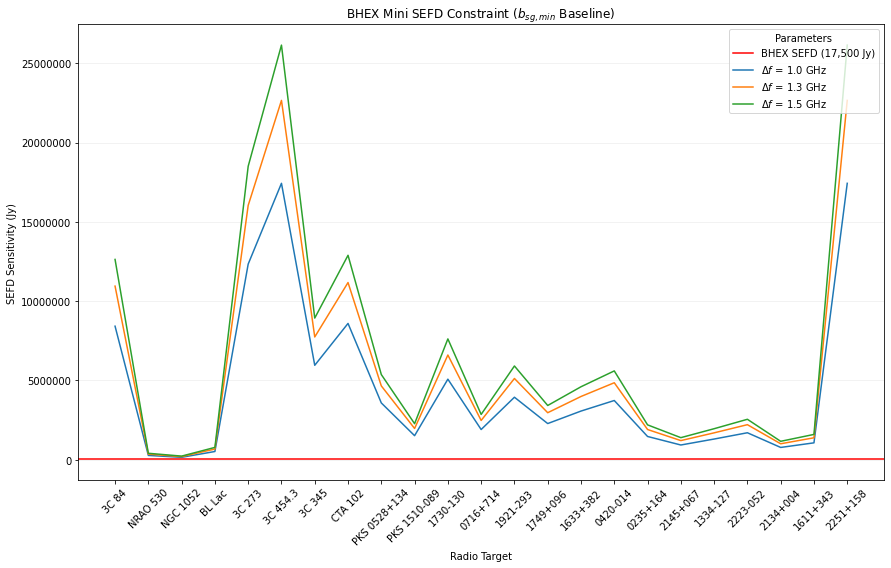

In [12]:
plt.figure(figsize=(12, 8))

# Define a range of bandwidths
bandwidths = np.array([1e9, 1.3e9, 1.5e9])  # Adjust to add more frequency bandwidths
plt.axhline(y=17500, color='r', linestyle='-', label="BHEX SEFD (17,500 Jy)")

for bandwidth in bandwidths:
  sg_min_sensitivities = []
  for i in range(0, len(radio_targets)):
    sg_min_sensitivities.append(SEFD_BHEXMini(df_thermal_noise.loc[i][4], 0.75, bandwidth, 100, 5000))

  plt.plot(df_csv["Target"], sg_min_sensitivities, linestyle="-", label=f'$\Delta f$ = {bandwidth/1e9:.1f} GHz')

plt.xlabel("Radio Target")
plt.ylabel("SEFD Sensitivity (Jy)")
plt.title("BHEX Mini SEFD Constraint ($b_{sg, min}$ Baseline)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.ticklabel_format(style='plain', axis='y') # This line formats the y-axis to display full numbers
plt.legend(loc="upper right", title="Parameters")
plt.grid(axis='y', alpha=0.2)
plt.savefig('BHEXMini_SEFD.png', dpi=300)
plt.show()

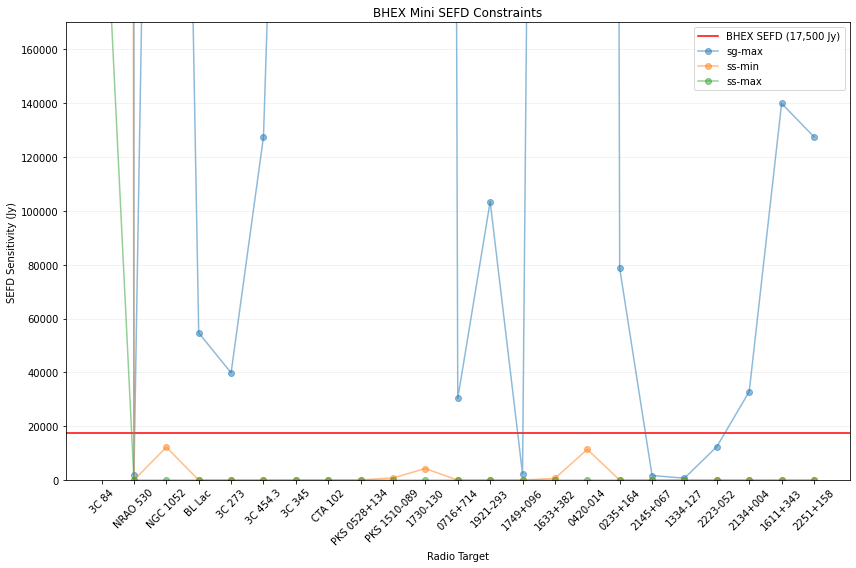

In [13]:
plt.figure(figsize=(12, 8))
plt.axhline(y=17500, color='r', linestyle='-', label = "BHEX SEFD (17,500 Jy)")
plt.plot(df_sensitivities["Target"], df_sensitivities["sg_max"], linestyle = "-", label = "sg-max", marker='o', alpha = 0.5)
plt.plot(df_sensitivities["Target"], df_sensitivities["ss_min"], linestyle = "-", label = "ss-min", marker='o', alpha = 0.5)
plt.plot(df_sensitivities["Target"], df_sensitivities["ss_max"], linestyle = "-", label = "ss-max", marker='o', alpha = 0.5)
plt.ylim([0,0.17e6])

plt.xlabel("Radio Target")
plt.ylabel("SEFD Sensitivity (Jy)")
plt.title("BHEX Mini SEFD Constraints")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(loc = "upper right")
plt.grid(axis='y', alpha=0.2)
plt.savefig('BHEXMiniSEFDBaselines.png', dpi=300)
plt.show()

### Calculate Antenna Diameter (Given $T_{sys}$)

In [14]:
def Antenna(T_sys, eta_A, SEFD):
    k = 1.38e-23  # Boltzmann constant in J/K
    SEFD_SI = SEFD * 1e-26  # Convert Jy to W/m²/Hz
    Area = (2*k*T_sys) / (eta_A * SEFD_SI)
    Diameter = 2*(Area/np.pi)**(0.5)
    return Diameter

antenna_ss_max = []
antenna_ss_min = []

antenna_sg_max = []
antenna_sg_min = []

for i in range(0, len(radio_targets)):
  antenna_ss_max.append(Antenna(100, 0.8, df_sensitivities.loc[i][1]))
  antenna_ss_min.append(Antenna(100, 0.8, df_sensitivities.loc[i][2]))

  antenna_sg_max.append(Antenna(100, 0.8, df_sensitivities.loc[i][3]))
  antenna_sg_min.append(Antenna(100, 0.8, df_sensitivities.loc[i][4]))

In [15]:
def get_antenna_diameters(T_sys):
  """
  Calculates the required antenna diameters for different baselines and a given system temperature.

  Args:
    T_sys (float): System temperature in Kelvin.

  Returns:
    pandas.DataFrame: A DataFrame containing the required antenna diameters for each target and baseline.
  """
  antenna_ss_max = []
  antenna_ss_min = []
  antenna_sg_max = []
  antenna_sg_min = []

  for i in range(0, len(radio_targets)):
    antenna_ss_max.append(Antenna(T_sys, 0.8, df_sensitivities.loc[i][1]))
    antenna_ss_min.append(Antenna(T_sys, 0.8, df_sensitivities.loc[i][2]))
    antenna_sg_max.append(Antenna(T_sys, 0.8, df_sensitivities.loc[i][3]))
    antenna_sg_min.append(Antenna(T_sys, 0.8, df_sensitivities.loc[i][4]))

  df_antenna = pd.DataFrame({
      "Target": df_csv["Target"],
      "ss_max": antenna_ss_max,
      "ss_min": antenna_ss_min,
      "sg_max": antenna_sg_max,
      "sg_min": antenna_sg_min
  })
  return df_antenna

df_antenna_variable_100k = get_antenna_diameters(100)
df_antenna_variable_110k = get_antenna_diameters(110)
df_antenna_variable_120k = get_antenna_diameters(120)
df_antenna_variable_130k = get_antenna_diameters(130)
df_antenna_variable_140k = get_antenna_diameters(140)

### Min Space-Ground Baseline (BHEX Mini - EHT)

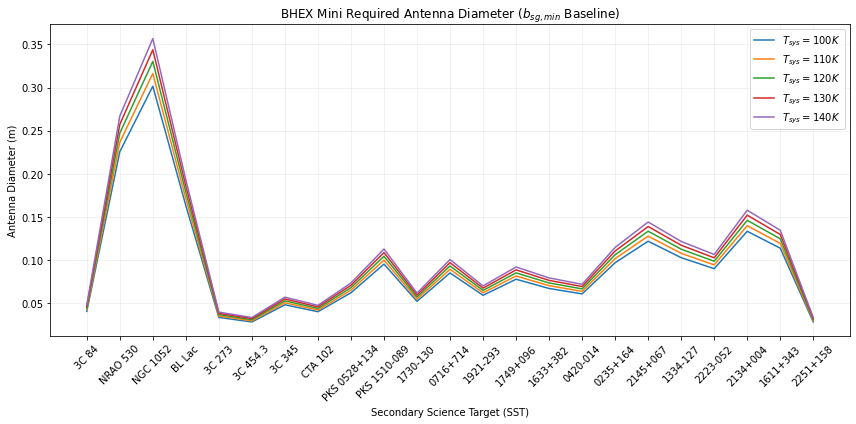

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(df_antenna_variable_100k['Target'], df_antenna_variable_100k['sg_min'], label = r"$T_{sys}=100K$")
plt.plot(df_antenna_variable_110k['Target'], df_antenna_variable_110k['sg_min'], label = r"$T_{sys}=110K$")
plt.plot(df_antenna_variable_120k['Target'], df_antenna_variable_120k['sg_min'], label = r"$T_{sys}=120K$")
plt.plot(df_antenna_variable_130k['Target'], df_antenna_variable_130k['sg_min'], label = r"$T_{sys}=130K$")
plt.plot(df_antenna_variable_140k['Target'], df_antenna_variable_140k['sg_min'], label = r"$T_{sys}=140K$")
plt.xlabel('Secondary Science Target (SST)')
plt.ylabel('Antenna Diameter (m)')
plt.title('BHEX Mini Required Antenna Diameter ($b_{sg, min}$ Baseline)')
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.legend()
plt.grid(True, alpha = 0.2)
plt.tight_layout()
plt.savefig('BHEXMiniAntenna_minBaseline.png', dpi=300)
plt.show()

### Max Space-Ground Baseline (BHEX Mini - EHT)

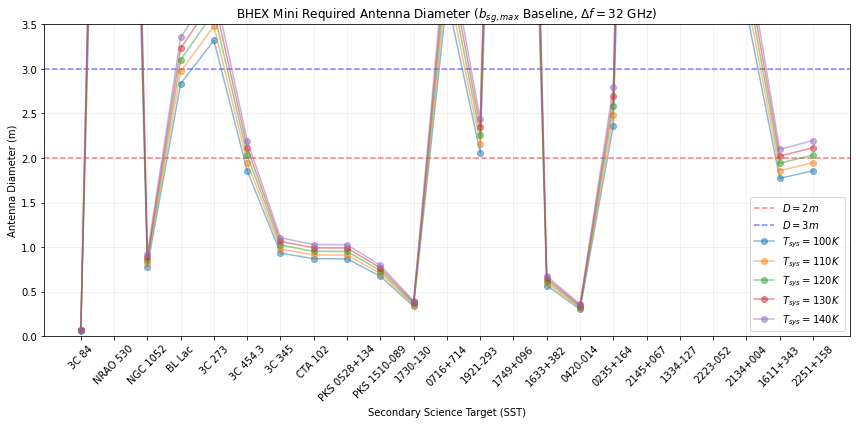

In [17]:
plt.figure(figsize=(12, 6))
plt.axhline(y=2, color='r', linestyle='--', label = "$D=2m$", alpha = 0.5)
plt.axhline(y=3, color='b', linestyle='--', label = "$D=3m$", alpha = 0.5)
plt.plot(df_antenna_variable_100k['Target'], df_antenna_variable_100k['sg_max'], label = r"$T_{sys}=100K$", marker='o', alpha = 0.5)
plt.plot(df_antenna_variable_110k['Target'], df_antenna_variable_110k['sg_max'], label = r"$T_{sys}=110K$", marker='o', alpha = 0.5)
plt.plot(df_antenna_variable_120k['Target'], df_antenna_variable_120k['sg_max'], label = r"$T_{sys}=120K$", marker='o', alpha = 0.5)
plt.plot(df_antenna_variable_130k['Target'], df_antenna_variable_130k['sg_max'], label = r"$T_{sys}=130K$", marker='o', alpha = 0.5)
plt.plot(df_antenna_variable_140k['Target'], df_antenna_variable_140k['sg_max'], label = r"$T_{sys}=140K$", marker='o', alpha = 0.5)
plt.xlabel('Secondary Science Target (SST)')
plt.ylabel('Antenna Diameter (m)')
plt.ylim([0, 3.5])
plt.title('BHEX Mini Required Antenna Diameter ($b_{sg, max}$ Baseline, $\Delta f = 32$ GHz)')
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.legend()
plt.grid(True, alpha = 0.2)
plt.tight_layout()
plt.savefig('BHEXMiniAntenna_MaxSG.png', dpi=300)
plt.show()

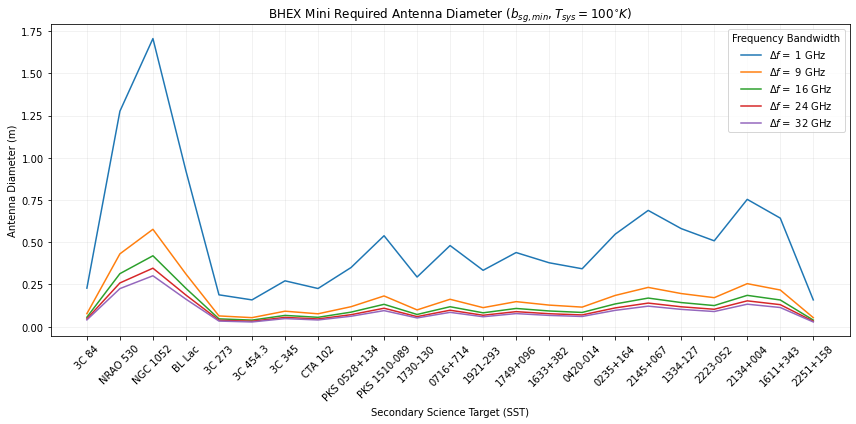

In [18]:
def get_antenna_diameters_variable_bandwidth(T_sys, bandwidth):
    """
    Calculates the required antenna diameters for different baselines with variable bandwidth.

    Args:
        T_sys (float): System temperature in Kelvin.
        bandwidth (float): Bandwidth in Hz.

    Returns:
        pandas.DataFrame: A DataFrame containing the required antenna diameters for each target and baseline.
    """
    ss_max_sensitivities = []
    ss_min_sensitivities = []
    sg_max_sensitivities = []
    sg_min_sensitivities = []

    for i in range(0, len(radio_targets)):
        ss_max_sensitivities.append(SEFD_BHEXMini(df_thermal_noise.loc[i][1], 0.75, bandwidth, 100, 17000))
        ss_min_sensitivities.append(SEFD_BHEXMini(df_thermal_noise.loc[i][2], 0.75, bandwidth, 100, 17000))
        sg_max_sensitivities.append(SEFD_BHEXMini(df_thermal_noise.loc[i][3], 0.75, bandwidth, 100, 5000))  # Change ground SEFD to avg. EHT SEFD across all ground stations
        sg_min_sensitivities.append(SEFD_BHEXMini(df_thermal_noise.loc[i][4], 0.75, bandwidth, 100, 5000))

    df_sensitivities_variable_bandwidth = pd.DataFrame({
        "Target": df_csv["Target"],
        "ss_max": ss_max_sensitivities,
        "ss_min": ss_min_sensitivities,
        "sg_max": sg_max_sensitivities,
        "sg_min": sg_min_sensitivities
    })

    antenna_ss_max = []
    antenna_ss_min = []
    antenna_sg_max = []
    antenna_sg_min = []

    for i in range(0, len(radio_targets)):
        antenna_ss_max.append(Antenna(T_sys, 0.8, df_sensitivities_variable_bandwidth.loc[i][1]))
        antenna_ss_min.append(Antenna(T_sys, 0.8, df_sensitivities_variable_bandwidth.loc[i][2]))
        antenna_sg_max.append(Antenna(T_sys, 0.8, df_sensitivities_variable_bandwidth.loc[i][3]))
        antenna_sg_min.append(Antenna(T_sys, 0.8, df_sensitivities_variable_bandwidth.loc[i][4]))

    df_antenna = pd.DataFrame({
        "Target": df_csv["Target"],
        "ss_max": antenna_ss_max,
        "ss_min": antenna_ss_min,
        "sg_max": antenna_sg_max,
        "sg_min": antenna_sg_min
    })
    return df_antenna

# Generate dataframes for different bandwidths with fixed T_sys = 100K
bandwidths = np.linspace(1e9, 32e9, 5) # Vary bandwidth from 1 GHz to 32 GHz

plt.figure(figsize=(12, 6))

for bw in bandwidths:
    df_antenna_variable_bw = get_antenna_diameters_variable_bandwidth(100, bw)
    plt.plot(df_antenna_variable_bw['Target'], df_antenna_variable_bw['sg_min'], label=f'$\Delta f =$ {bw/1e9:.0f} GHz')

plt.xlabel('Secondary Science Target (SST)')
plt.ylabel('Antenna Diameter (m)')
plt.title(r'BHEX Mini Required Antenna Diameter ($b_{sg,min}, T_{sys}=100^{\circ}K$)')
plt.xticks(rotation=45)
plt.legend(title = "Frequency Bandwidth")
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.savefig('BHEXMini_AntennaFinal.png', dpi=300)
plt.show()


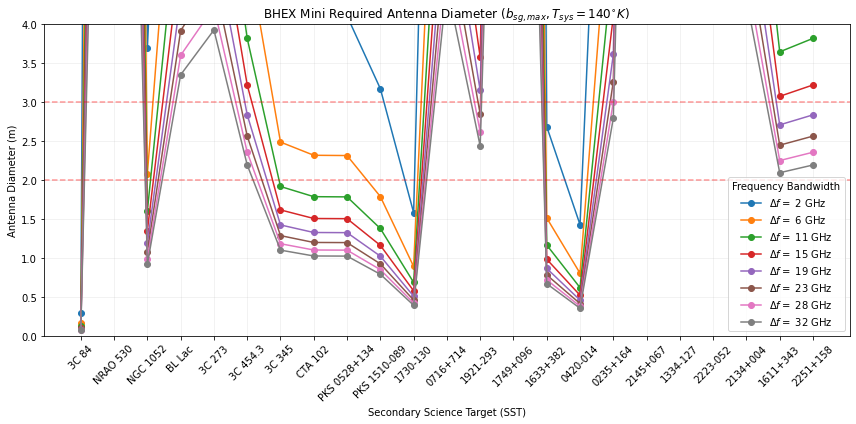

In [19]:
bandwidths = np.linspace(2e9, 32e9, 8) # Vary bandwidth from 1 GHz to 32 GHz

plt.figure(figsize=(12, 6))

for bw in bandwidths:
    df_antenna_variable_bw = get_antenna_diameters_variable_bandwidth(140, bw)
    plt.plot(df_antenna_variable_bw['Target'], df_antenna_variable_bw['sg_max'], marker='o', label=f'$\Delta f =$ {bw/1e9:.0f} GHz')

plt.xlabel('Secondary Science Target (SST)')
plt.ylabel('Antenna Diameter (m)')
plt.title(r'BHEX Mini Required Antenna Diameter ($b_{sg,max}, T_{sys}=140^{\circ}K$)')
plt.axhline(y=3, color='r', linestyle='--', alpha = 0.4)
plt.axhline(y=2, color='r', linestyle='--', alpha = 0.4)
plt.ylim([0, 4])
plt.xticks(rotation=45)
plt.legend(title = "Frequency Bandwidth")
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.savefig('BHEXMini_AntennaFinal.png', dpi=300)
plt.show()

### Min Space-Space Baseline (BHEX - BHEX Mini)

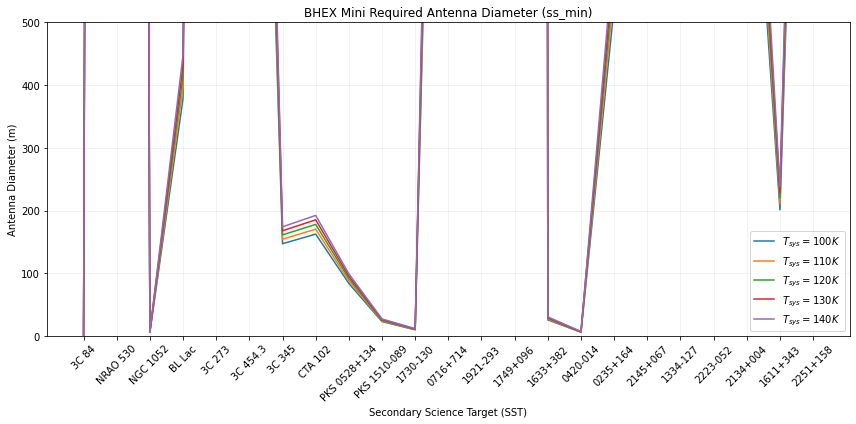

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(df_antenna_variable_100k['Target'], df_antenna_variable_100k['ss_min'], label = r"$T_{sys}=100K$")
plt.plot(df_antenna_variable_110k['Target'], df_antenna_variable_110k['ss_min'], label = r"$T_{sys}=110K$")
plt.plot(df_antenna_variable_120k['Target'], df_antenna_variable_120k['ss_min'], label = r"$T_{sys}=120K$")
plt.plot(df_antenna_variable_130k['Target'], df_antenna_variable_130k['ss_min'], label = r"$T_{sys}=130K$")
plt.plot(df_antenna_variable_140k['Target'], df_antenna_variable_140k['ss_min'], label = r"$T_{sys}=140K$")
plt.xlabel('Secondary Science Target (SST)')
plt.ylabel('Antenna Diameter (m)')
plt.title('BHEX Mini Required Antenna Diameter (ss_min)')
plt.ylim([0, 500])
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.legend()
plt.grid(True, alpha = 0.2)
plt.tight_layout()
plt.savefig('BHEXMiniAntenna.png', dpi=300)
plt.show()

<ipython-input-21-0e0a4baf97db>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 6))


<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

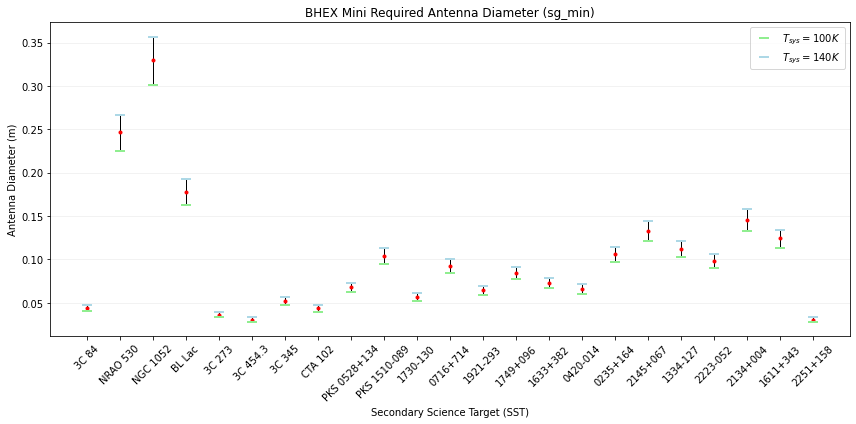

In [21]:
# Calculate the mean antenna diameter for each target across the temperature range 100K to 140K (inclusive)
temperatures = [100, 110, 120, 130, 140]
mean_diameters = []

for i in range(len(radio_targets)):
    diameters_for_target = []
    for T_sys in temperatures:
        df_antenna_variable_Tsys = get_antenna_diameters(T_sys)
        diameters_for_target.append(df_antenna_variable_Tsys.loc[i, 'sg_min'])
    mean_diameters.append(np.mean(diameters_for_target))

    plt.figure(figsize=(12, 6))

# Calculate min and max diameters for sg_min across T_sys = 100K and T_sys = 140K
min_diameters = df_antenna_variable_100k['sg_min']
max_diameters = df_antenna_variable_140k['sg_min']

for i, target in enumerate(df_antenna_variable_100k['Target']):
    # Plot vertical line connecting min and max
    plt.plot([i, i], [min_diameters[i], max_diameters[i]], color='black', linestyle='-', linewidth=1)
    # Plot markers for min and max
    plt.plot(i, mean_diameters[i], 'o', color='red', markersize=3)
    plt.plot(i, min_diameters[i], '_', color='lightgreen', markersize=10, markeredgewidth=2, label=r'$T_{sys}=100K$' if i == 0 else "")
    plt.plot(i, max_diameters[i], '_', color='lightblue', markersize=10, markeredgewidth=2, label=r'$T_{sys}=140K$' if i == 0 else "")

plt.xticks(range(len(df_antenna_variable_100k['Target'])), df_antenna_variable_100k['Target'], rotation=45)
plt.xlabel('Secondary Science Target (SST)')
plt.ylabel('Antenna Diameter (m)')
plt.title('BHEX Mini Required Antenna Diameter (sg_min)')
plt.grid(axis='y', alpha=0.2)
plt.legend() # Add legend to show labels for min and max markers
plt.tight_layout()
plt.savefig('BHEXMiniAntennas.png', dpi=300)
plt.show()

### Revised Thermal Noise Plot

In [22]:
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd

# # Select only 5 representative radio targets for cleaner visualization
# radio_targets = [
#     ("3C 84", 3.06, 20),
#     ("3C 273", 3.72, 66),
#     ("BL Lac", 0.76, 52),
#     ("PKS 1510-089", 1.30, 43),
#     ("1334-127", 1.21, 72)
# ]

# df_csv = pd.DataFrame(radio_targets, columns=["Target", "Flux Density (Jy)", "Angular Size (μas)"])

# # Calculate visibility amplitudes for all targets and baselines
# V_ss_max, V_ss_min, V_sg_max, V_sg_min = [], [], [], []

# for i in range(len(radio_targets)):
#     V_ss_max.append(visibility_amplitude(df_csv.loc[i, "Flux Density (Jy)"], df_csv.loc[i, "Angular Size (μas)"], ss_max))
#     V_ss_min.append(visibility_amplitude(df_csv.loc[i, "Flux Density (Jy)"], df_csv.loc[i, "Angular Size (μas)"], ss_min))
#     V_sg_max.append(visibility_amplitude(df_csv.loc[i, "Flux Density (Jy)"], df_csv.loc[i, "Angular Size (μas)"], sg_max))
#     V_sg_min.append(visibility_amplitude(df_csv.loc[i, "Flux Density (Jy)"], df_csv.loc[i, "Angular Size (μas)"], sg_min))

# df_visibility = pd.DataFrame({
#     "Target": df_csv["Target"],
#     "V_ss_max": V_ss_max,
#     "V_ss_min": V_ss_min,
#     "V_sg_max": V_sg_max,
#     "V_sg_min": V_sg_min
# })

# # Enhanced Plot: Mean thermal noise with range (min to max) as horizontal line segments
# SNR_values = np.linspace(5, 10, 6)  # SNR from 5 to 10
# baseline_types = ["V_ss_max", "V_ss_min", "V_sg_max", "V_sg_min"]
# baseline_labels = ["Max $b_{ss}$", "Min $b_{ss}$", "Max $b_{sg}$", "Min $b_{sg}$"]

# plt.figure(figsize=(12, 6))

# x_positions = np.arange(len(baseline_labels))

# # Use distinct colors for the 5 targets
# colors = ['blue', 'green', 'orange', 'purple', 'pink']

# # Create offset positions for each target to avoid overlap
# target_offsets = np.linspace(-0.2, 0.2, len(radio_targets))

# for target_idx in range(len(radio_targets)):
#     target_name = df_visibility.loc[target_idx, "Target"]

#     means = []
#     mins = []
#     maxs = []

#     for baseline_type in baseline_types:
#         V = df_visibility.loc[target_idx, baseline_type]

#         # Calculate thermal noise for all SNR values
#         thermal_noises = [thermalNoise_constraint(V, snr) for snr in SNR_values]

#         # Calculate statistics
#         mean_noise = np.mean(thermal_noises)
#         min_noise = np.min(thermal_noises)  # This occurs at SNR=10
#         max_noise = np.max(thermal_noises)  # This occurs at SNR=5

#         means.append(mean_noise)
#         mins.append(min_noise)
#         maxs.append(max_noise)

#     # Offset x positions for each target to avoid overlap
#     x_pos = x_positions + target_offsets[target_idx]

#     # Plot horizontal line segments from min to max for each baseline
#     for i in range(len(baseline_labels)):
#         # Horizontal line showing range
#         plt.plot([mins[i], maxs[i]], [x_pos[i], x_pos[i]],
#                 color=colors[target_idx], linewidth=3, alpha=0.4,
#                 label=target_name if i == 0 else "")  # Only label once per target

#         # Add small vertical markers at min and max points
#         plt.plot([mins[i], mins[i]], [x_pos[i] - 0.03, x_pos[i] + 0.03],
#                 color=colors[target_idx], linewidth=2.5, alpha = 0.4)
#         plt.plot([maxs[i], maxs[i]], [x_pos[i] - 0.03, x_pos[i] + 0.03],
#                 color=colors[target_idx], linewidth=2.5, alpha = 0.4)

#     # Plot mean as red dots
#     plt.scatter(means, x_pos, color='red', s=60, alpha=0.4, zorder=10)

# plt.scatter(0, 0, color='red', s=60, alpha=0.3, zorder=10, label = "Average $\sigma$")

# plt.axvline(x=7e-3, label = "$\sigma_{BHEX-ALMA}$ at $\Delta t=10s$")

# plt.gca().xaxis.tick_top()
# plt.gca().xaxis.set_label_position('top')

# plt.ylabel("Baseline Type")
# plt.xlabel("Thermal Noise Constraint (Jy)")
# plt.title("BHEX Mini Thermal Noise Constraints")
# plt.yticks(x_positions, baseline_labels)
# plt.grid(alpha=0.3, axis='x')

# # Legend showing all 5 targets
# plt.legend(loc='lower right', title="Secondary Science Targets")
# plt.tight_layout()
# plt.savefig('BHEXMini_ThermalNoiseConstraint.png', dpi=300)
# plt.show()

# print("Sample Analysis with 5 Radio Targets:")
# print("=" * 50)
# print("Selected targets:")
# for i, target in enumerate(radio_targets):
#     print(f"  {i+1}. {target[0]} - {colors[i]}")

In [23]:
import numpy as np

def coherenceLoss(freq, time, allDev):
    return 1-np.exp(-2*(np.pi*freq*time*allDev)**2)

coherenceLoss(86e9, 100, 5e-11)

1.0